In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import seaborn as sns 
import numpy as np
import cv2
import pandas as pd
from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tqdm import tqdm_notebook


from keras.models import Model
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras import backend as K
from keras.layers.core import Lambda

In [ ]:
!pip install -q kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=acc52be01a1878cb2c5dc1cc70c305962396ed3e99352f48743f73da175e9e48
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gogeta054","key":"4050acc7237b4c47f2e9b7aa96880731"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              223KB  2021-04-10 08:12:55           2400        254  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1397        150  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1051        109  1.0              
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020

In [ ]:
!kaggle competitions download -c severstal-steel-defect-detection

 99% 1.56G/1.57G [00:11<00:00, 121MB/s]
100% 1.57G/1.57G [00:11<00:00, 141MB/s]


In [ ]:
!mkdir sheet-metal-dataset

In [ ]:
!unzip /content/severstal-steel-defect-detection.zip -d /content/sheet-metal-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/sheet-metal-dataset/train_images/99f75320d.jpg  
  inflating: /content/sheet-metal-dataset/train_images/99f9d2375.jpg  
  inflating: /content/sheet-metal-dataset/train_images/99fd3c6f5.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a016fe15.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a064450d.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a08c2783.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a18e4457.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a1f7c238.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a2523ce9.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a3e774ff.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a5e9e77c.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a5f7a855.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a62177bb.jpg  
  inflating: /content/shee

In [ ]:
img_path = './sheet-metal-dataset/test_images/004f40c73.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.
img = np.expand_dims(img, axis=-1)

In [ ]:
np.shape(img)

(256, 1600, 1)

In [ ]:
train_df = pd.read_csv('./sheet-metal-dataset/train.csv')
print(train_df.shape)

(7095, 3)


In [ ]:
mask_count_df = train_df.groupby('ImageId')["ClassId"].count().reset_index().rename(columns = {"ClassId":"Num_ClassId"})
mask_count_df.sort_values('Num_ClassId', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(6666, 2)


,ImageId,Num_ClassId
6253,ef24da2ba.jpg,3
5740,db4867ee8.jpg,3
3435,84865746c.jpg,2
2203,5665ada1b.jpg,2
6149,eb44ad79d.jpg,2


In [ ]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T


def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [ ]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, Rotate,IAAAffine
)
aug_null = Compose([])
aug = Compose([ 
    Blur(p=0.5, blur_limit=2),
    HorizontalFlip(p=0.5),              
    Rotate(limit=5, p=0.3),
    VerticalFlip(p=0.5), 
])

In [ ]:
import keras
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='./sheet-metal-dataset/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2021, shuffle=True,
                aug=aug_null):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.aug = aug
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            #print(np.shape(y))
            #print(len(X))
            
            for img in range(len(X)):
                # Store class
                #print(np.shape(X[img]),np.shape(y[img]))
                #masks0 = [y[img][:,:,0],y[img][:,:,1],y[img][:,:,2],y[img][:,:,3]]
                
                augmented = self.aug(image=X[img], mask=y[img] )#masks0)
                
                X[img] = augmented['image']
                y[img] = augmented['mask']
                #print(":", end = '')
                #y[img][:,:,0] = augmented['masks'][0]
                #y[img][:,:,1] = augmented['masks'][1]
                #y[img][:,:,2] = augmented['masks'][2]
                #y[img][:,:,3] = augmented['masks'][3]
                                
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            #print()
            #print("i",i)
            #print("ID",ID)
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name].copy().reset_index()
            #print("image_df:",image_df)

            masks = np.zeros((*self.dim, self.n_classes))
            
            for j in range(len(image_df)):
                #print(j)
                rle = image_df.loc[j,'EncodedPixels']
                cls =  image_df.loc[j,'ClassId']
                masks[:, :, cls-1] = rle2mask(rle, self.dim)
    
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [ ]:
BATCH_SIZE = 16
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(
    mask_count_df.index, 
    random_state=2021, 
    test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4,
)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
from keras.models import load_model
dict = {
    "dice_coef": dice_coef
}
model = load_model('my_model.h5', custom_objects=dict)

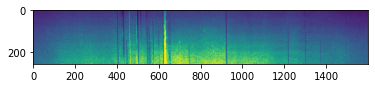

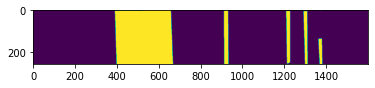

In [ ]:
x,y = train_generator.__getitem__(0)
plt.imshow(np.squeeze(x[0]))
plt.show()
plt.imshow(np.squeeze(y[0])[:,:,2])
plt.show()

pred = model.predict_on_batch(x)

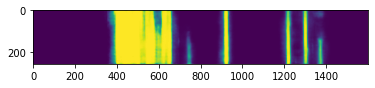

In [ ]:
img = pred[0]
plt.imshow(np.squeeze(img)[:,:,2])